## Rise in Covid-19 cases prediction Model

----
## Exploring the Data
Code cell below will load necessary Python libraries and load the covid-19 data. Note that the column from this dataset, `'new_cases'`, will be our target label (Which is the rise and fall of cases). All other columns are features about each individual in the dataset.

In [166]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.impute import SimpleImputer

# Import supplementary visualization code visuals.py
import visualscp2 as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("owid-covid-data.csv")

# Deleting some features that are not too much important for this model
data = data.drop(["date", 'continent', 'iso_code', 'total_tests', 'new_tests', 'tests_units', 'total_cases', 'total_deaths', 'total_cases_per_million', 'new_cases_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'new_deaths', 'extreme_poverty', 'female_smokers', 'male_smokers', 'handwashing_facilities'], axis=1)

# Checking misisng values
missing_values_count = data.isnull().sum()
print(missing_values_count[0:34])

print("missing are: ")
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()
print((total_missing/total_cells)*100)

data = data.dropna()
data["new_cases"] = data["new_cases"].fillna(0)
data["stringency_index"] = data["stringency_index"].fillna(0.0)
data = data.drop(["stringency_index"], axis=1)
data["hospital_beds_per_thousand"] = data["hospital_beds_per_thousand"].fillna(data["hospital_beds_per_thousand"].mean())
data = data.drop(["hospital_beds_per_thousand"], axis=1)
# data["diabetes_prevalence"] = data["diabetes_prevalence"].fillna(data["diabetes_prevalence"].mean())
data = data.drop(["diabetes_prevalence"], axis=1)
# data["cvd_death_rate"] = data["cvd_death_rate"].fillna(data["cvd_death_rate"].mean())
data = data.drop(["cvd_death_rate"], axis=1)
data["median_age"] = data["median_age"].fillna(data["median_age"].mean())
# data = data.drop(["median_age"], axis=1)
# data["aged_65_older"] = data["aged_65_older"].fillna(data["aged_65_older"].mean())
data = data.drop(["aged_65_older"], axis=1)
# data["aged_70_older"] = data["aged_70_older"].fillna(data["aged_70_older"].mean())
data = data.drop(["aged_70_older"], axis=1)
# data["gdp_per_capita"] = data["gdp_per_capita"].fillna(data["gdp_per_capita"].mean())
data = data.drop(["gdp_per_capita"], axis=1)
data["population_density"] = data["population_density"].fillna(data["population_density"].mean())
# data = data.drop(["population_density"], axis=1)#
# data["life_expectancy"] = data["life_expectancy"].fillna(data["life_expectancy"].mean())
data = data.drop(["life_expectancy"], axis=1)

# data=data[0:26069]
# data = data[data.location != "International"]
# data = data[data.location != "World"]

# data = data.drop(["location"], axis=1)
# nan_values = data.isna()
# nan_columns = nan_values.any()

# columns_with_nan = data.columns[nan_columns]
# print(columns_with_nan)

# Success - Display the first record
display(data)

location                         0
new_cases                      230
stringency_index              5241
population                      64
population_density            1132
median_age                    2511
aged_65_older                 2844
aged_70_older                 2632
gdp_per_capita                2776
cvd_death_rate                2496
diabetes_prevalence           1718
hospital_beds_per_thousand    4511
life_expectancy                362
dtype: int64
missing are: 
7.8050402952828914


,location,new_cases,population,population_density,median_age
1,Afghanistan,0.0,38928341.0,54.422,18.6
2,Afghanistan,0.0,38928341.0,54.422,18.6
3,Afghanistan,0.0,38928341.0,54.422,18.6
4,Afghanistan,0.0,38928341.0,54.422,18.6
5,Afghanistan,0.0,38928341.0,54.422,18.6
...,...,...,...,...,...
25884,Zimbabwe,7.0,14862927.0,42.729,19.6
25885,Zimbabwe,62.0,14862927.0,42.729,19.6
25886,Zimbabwe,16.0,14862927.0,42.729,19.6
25887,Zimbabwe,7.0,14862927.0,42.729,19.6


----
## Preparing the Data
Before data can be used as input for regression model, we will clean the data, format it , and restructured it for best possible results. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

In [167]:
# Split the data into features and target label
covid_cases = data['new_cases']
features_raw = data.drop('new_cases', axis = 1)

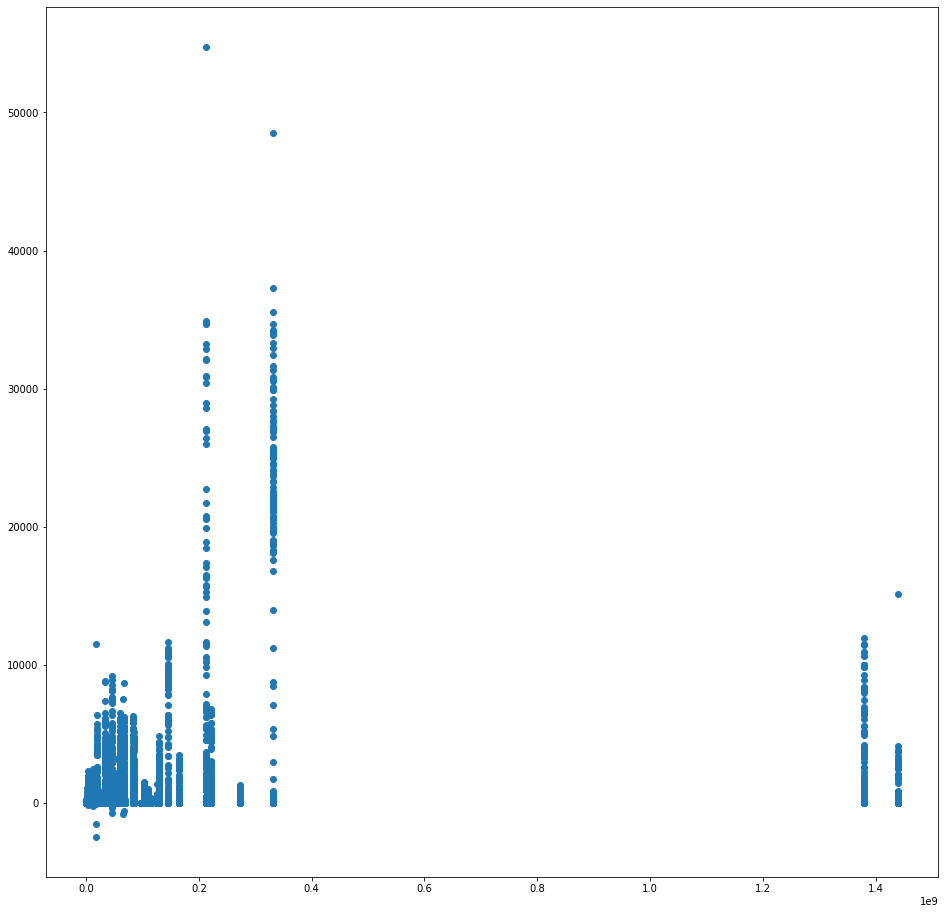

In [168]:
#plotting data in graph
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
plt.scatter(features_raw["population"], covid_cases)

### Normalizing Numerical Features
Now we will perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution; however, normalization ensures that each feature is treated equally when applying supervised learners.

In [169]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['population']


features_log_minmax_transform = pd.DataFrame(data = features_raw)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_raw[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.tail(n = 5))

,location,population,population_density,median_age
25884,Zimbabwe,0.010259,42.729,19.6
25885,Zimbabwe,0.010259,42.729,19.6
25886,Zimbabwe,0.010259,42.729,19.6
25887,Zimbabwe,0.010259,42.729,19.6
25888,Zimbabwe,0.010259,42.729,19.6


### One Hot Encoding

There is a feature `test_units` which is non-numeric. Learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. We will convert this by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |


In [170]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(data=features_log_minmax_transform)
display(features_final.head(n=10))
# features_final = features_log_minmax_transform
# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

,population,population_density,median_age,location_Afghanistan,location_Albania,location_Algeria,location_Argentina,location_Australia,location_Austria,location_Azerbaijan,...,location_United Arab Emirates,location_United Kingdom,location_United States,location_Uruguay,location_Uzbekistan,location_Venezuela,location_Vietnam,location_Yemen,location_Zambia,location_Zimbabwe
1,0.02698,54.422,18.6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.02698,54.422,18.6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.02698,54.422,18.6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.02698,54.422,18.6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0.02698,54.422,18.6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0.02698,54.422,18.6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0.02698,54.422,18.6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0.02698,54.422,18.6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0.02698,54.422,18.6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0.02698,54.422,18.6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


146 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. We will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [171]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    covid_cases, 
                                                    test_size = 0.2, 
                                                    random_state = 3,
                                                    shuffle = True)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 14250 samples.
Testing set has 3563 samples.


----
## Evaluating Model Performance
In this section, we will investigate different algorithms, and determine which is best at modeling the data.

###  Supervised Learning Models
**The following are some of the supervised learning models, we will check the model performance and select one of them for our final results:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Function for Training and Predicting data on different algorithms
To properly evaluate the performance of each model, we will create a training and predicting function that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

In [172]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

def train_predict(supervised_learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - supervised_learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Traning the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    supervised_learner = supervised_learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculating the training time
    results['train_time'] = start - end
        
    # Predictions on the test set(X_test),
    #  then predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = supervised_learner.predict(X_test)
    predictions_train = supervised_learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculating the total prediction time
    results['pred_time'] = start- end
            
    # Computing accuracy on the first 300 training samples which is y_train[:300]
    results['err_train'] = max_error(predictions_train, y_train[:300])
        
    # Computing accuracy on test set using accuracy_score()
    results['err_test'] = max_error(predictions_test, y_test)
    
    # Computing F-score on the the first 300 training samples using fbeta_score()
    results['r2_score_train'] = r2_score(predictions_train, y_train[:300])
    
    # Computing F-score on the test set which is y_test
    results['r2_score_test'] = r2_score(predictions_test, y_test)
       
    # Success
    print("{} trained on {} samples.".format(supervised_learner.__class__.__name__, sample_size))
    print("Training: max_error: {} r2_score: {}.".format(results['err_train'], results['r2_score_train']))
    print("Testing: max_error: {} r2_score: {}.".format(results['err_test'], results['r2_score_test']))
    
    # Return the results
    return results

### Initial Model Evaluation
In the code cell, we will import the supervised learning models and then start training the data on them.
We will split the our data in `'data_sample_1'`, `'data_sample_10'`, and `'data_sample_100'` respectively:
- `'data_sample_1'` = 1% of training data,
- `'data_sample_10'` = 10% of training data,
- `'data_sample_100'` = 100% of training data,
    

DecisionTreeRegressor trained on 1 samples.
Training: max_error: 29905.0 r2_score: 0.0.
Testing: max_error: 48525.0 r2_score: 0.0.
DecisionTreeRegressor trained on 14 samples.
Training: max_error: 29722.0 r2_score: -257.61852144643916.
Testing: max_error: 48342.0 r2_score: -239.7505978483122.
DecisionTreeRegressor trained on 142 samples.
Training: max_error: 26807.0 r2_score: 0.32630863589250925.
Testing: max_error: 33252.0 r2_score: 0.24416168304782393.
Ridge trained on 1 samples.
Training: max_error: 29905.0 r2_score: 0.0.
Testing: max_error: 48525.0 r2_score: 0.0.
Ridge trained on 14 samples.
Training: max_error: 29610.007016257667 r2_score: -396.0086252758657.
Testing: max_error: 48230.00701625767 r2_score: -407.53011428754934.
Ridge trained on 142 samples.
Training: max_error: 18303.30279796987 r2_score: 0.1188997417480342.
Testing: max_error: 32356.561930981297 r2_score: -0.19410700672102665.
SVR trained on 1 samples.
Training: max_error: 29905.0 r2_score: 0.0.
Testing: max_error

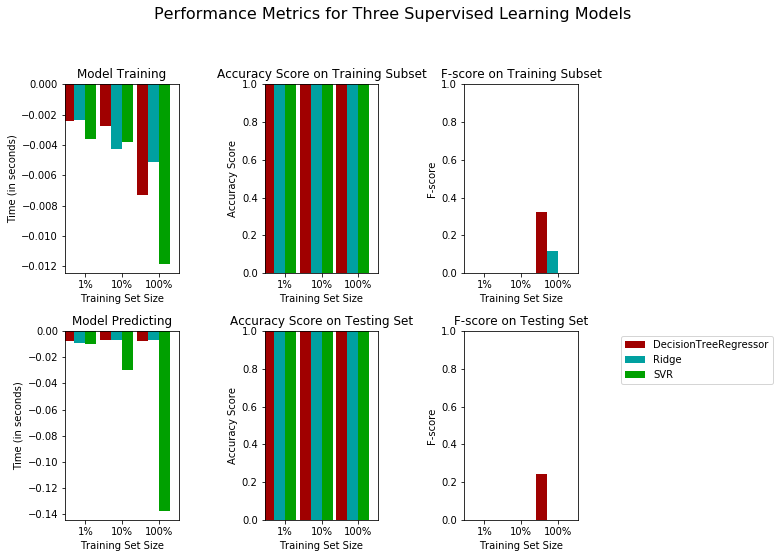

In [175]:
# Import the three supervised learning models from sklearn
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn import linear_model

# Initialize the three models
clf_A = DecisionTreeRegressor()
clf_B = linear_model.Ridge()
clf_C = svm.SVR(kernel="rbf")

# Calculating the number of samples for 1%, 10%, and 100% of the training data
data_sample_100 = len(y_train)
data_sample_100 = int((1 / 100) * data_sample_100)
data_sample_10 = int((10 / 100) * data_sample_100)
data_sample_1 = int((1 / 100) * data_sample_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([data_sample_1, data_sample_10, data_sample_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results)